In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade redner-gpu


     |████████████████████████████████| 31.8 MB 1.2 MB/s 


In [ ]:
import pyredner
import torch
import redner
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import os
from IPython.display import HTML
%matplotlib inline

In [ ]:
%cd drive/MyDrive/BigDataHub/Differentiable_Render/

/content/drive/MyDrive/BigDataHub/Differentiable_Render


In [ ]:
#Defiine normal images optimaization class
class Optim_cam_sametypeimage():
  def __init__(self, base_dir, model_path, env_p, cam_p):
    self.base_dir = base_dir
    #initialize the 3D scene
    print("initialze scence elements ... ")
    self.cam, self.shapes, self.materials, self.envmap =load_3dmodel_initial(base_dir, model_path, cam_p, env_path=env_p)
    
    # We don't setup any light source here
    # Construct the scene
    print("initialze scence  ... ")
    self.scene = pyredner.Scene(self.cam, self.shapes, self.materials, area_lights = [], envmap = self.envmap)

    self.tg_depth = None
    self.tg_normal = None

    #set the cam-pose for initializing source image
    self.cam_s_pose =None
    self.cam_s_lookat = None
    

  def render_model(self, cam_pose=None, cam_lookat=None, up=torch.tensor([.0, 1.0, .0]), num_samples=16, t=0):
    if cam_pose is not None:
      self.cam.position = cam_pose
      self.cam.look_at = cam_lookat

    self.cam.up = up  # airplane z axis point upwards

    # Serialize the scene
    # Here we specify the output channels as "depth", "shading_normal"
    scene_args = pyredner.RenderFunction.serialize_scene(scene = self.scene, num_samples = num_samples, max_bounces = 0, \
                channels = [redner.channels.depth, redner.channels.shading_normal])
    
    # Render the scene as our target image.
    render = pyredner.RenderFunction.apply
    # Render. The first argument is the seed for RNG in the renderer.
    img = render(t, *scene_args)
    return img

  def show_initiaol_case(self):
    img = self.render_model()
    
    depth = img[:, :, 0]
    normal = img[:, :, 1:4]

    # Save the images.
    # pyredner.imwrite(normal.cpu(), './results/test_vertex_color/normal.png')
  
    # visualization  
    plt.figure(figsize=(20, 20))
    plt.subplot(1,2,1)
    plt.imshow(depth.data.cpu())
    plt.subplot(1,2,2)
    plt.imshow(normal.data.cpu())


  def set_source_img(self, cam_pose, cam_lookat):
    # set the cam parameter which needed to be optimized
    self.cam_s_pose = cam_pose
    self.cam_s_lookat = cam_lookat

    img = self.render_model(cam_pose, cam_lookat)
    s_depth = img[:, :, 0]
    s_normal = img[:, :, 1:4]

    # visualize the difference between source image and target image
    visualize_img_diff(self.tg_normal, s_normal)


  def set_target_img(self, cam_pose, cam_lookat):
    img = self.render_model(cam_pose, cam_lookat)
    self.tg_depth = img[:, :, 0]
    self.tg_normal = img[:, :, 1:4]

    # visualization  
    plt.figure(figsize=(20, 20))
    plt.subplot(1,2,1)
    plt.imshow(img[:, :, 0].data.cpu())
    plt.subplot(1,2,2)
    plt.imshow(img[:, :, 1:4].data.cpu())

  def get_render_bycam(self, cam_pose, cam_lookat):
    img = self.render_model(cam_pose, cam_lookat)

    depth = img[:, :, 0]
    normal = img[:, :, 1:4]

    return [depth, normal]
  
  def get_source_img():
    pass
  
  def compute_loss(self, s_normal, s_depth):
      n = self.tg_normal.shape[0]*self.tg_normal.shape[1]

      #loss = normal
      # Compute the loss function. Here it is L2.
      #loss1
      #loss = (depth - target_depth).pow(2).sum()/200  + 100*(normal - target_normal).pow(2).sum() --- this lss doesn't work well for rotation

      #loss2 -- good and faster 
      #loss = (depth - target_depth).pow(2).sum()/n   + 100*(normal - target_normal).pow(2).sum()

      #loss3  -- good but slower
      #loss = (depth - target_depth).pow(2).sum()/n -  (depth - target_depth).sum().pow(2)/(n*n)

      #loss4 -- add gradient of difference between prediction and ground truth
      # forces the difference between neighboring pixel di and dj to be as minimum as possible
      # dx, dy = img_grad(depth - target_depth)
      # loss = (depth - target_depth).pow(2).sum()/n - (depth - target_depth).sum().pow(2)/(n*n) \
      #       +   (dx.pow(2) + dy.pow(2)).sum()/n

      #loss5 
      # dx_p, dy_p = img_grad(depth)
      # dx_gt, dy_gt = img_grad(target_depth)
      # loss = (depth - target_depth).pow(2).sum()/n - (depth - target_depth).sum().pow(2)/(n*n) \
      #           +  ((dx_p - dx_gt).pow(2) + (dy_p -dy_gt).pow(2)).sum()/n
                  
      # only normal info
      loss = (s_normal - self.tg_normal).pow(2).sum()/n +  (s_normal - self.tg_normal).sum().pow(2)/(n*n)
      
      return loss

  def optimization_process(self, num_iters=100):
      ## Set optimizer optimization
      # cam_p_optimizer = torch.optim.Adam([self.cam_s_pose], lr=0.2)
      # cam_lk_optimizer = torch.optim.Adam([self.cam_s_lookat], lr=0.1)
      cam_optimizer = torch.optim.Adam([self.cam_s_pose, self.cam_s_lookat], lr=0.2)

      imgs, losses = [], []
      norml_imgs = []

      subdir = 'airplane10'
      best_performance = [1000.0]


      for t in range(num_iters):
          cam_optimizer.zero_grad()
          # cam_p_optimizer.zero_grad()
          # cam_lk_optimizer.zero_grad()

          img = self.render_model(self.cam_s_pose, self.cam_s_lookat, num_samples=4, t=t+1)

          s_depth = img[:, :, 0]
          s_normal = img[:, :, 1:4]

          #store the rendered normal imgs
          norml_imgs.append(s_normal.data.cpu())

          print("compute loss==========")
          #Save the images.

          loss = self.compute_loss(s_normal, s_depth)

          print('loss:', loss.item())

          #rocord best performance
          # if loss.item() <= best_performance[0]:
          #   best_performance = []
          #   best_performance.append(loss.item())
          #   best_performance.append(cam_pose.cpu().tolist())
          #   best_performance.append(lookat.cpu().tolist())
            
              
          # Backpropagate the gradients.
          loss.backward()
          # Take a gradient descent step.
          # cam_p_optimizer.step()
          # cam_lk_optimizer.step()

          cam_optimizer.step()

          # Plot the loss
          f, (ax_loss, ax_img) = plt.subplots(1, 2, figsize = (20,10))
          losses.append(loss.data.item())
          
          diff = s_normal - self.tg_normal
          #save diff to generate animation
          save_training_imgs("", "airplane", diff, "diff", t)
          
          clear_output(wait=True)
          ax_loss.plot(range(len(losses)), losses, label='loss')
          ax_loss.legend()
          ax_img.imshow(torch.abs(diff).data.cpu())
          plt.show()

          print("cam pose====", cam_pose)
          print("cam lookat===", lookat)

  



In [ ]:
def save_training_imgs(base_dir,subdir,img, name, t):
    
    # pyredner.imwrite(s_img.cpu(),
    #     base_dir+'results/test_g_buffer/{}/iter_normal_{}.png'.format(subdir,t),
    #     normalize = True)

    pyredner.imwrite(torch.abs(img).data.cpu(),
      base_dir+'results/test_g_buffer/{}/iter_{}_{}.png'.format(subdir,name,t),
      normalize = True)

In [ ]:
def visualize_img_diff(target, source):
  # visualization difference between intit and target images
  f, (tg, s, diff) = plt.subplots(1,3, figsize= (20,20))

  tg.imshow(target.data.cpu())
  tg.axis('off')

  s.imshow(source.data.cpu())
  s.axis('off')

  diff.imshow((torch.abs(target - source).data.cpu()))
  diff.axis('off')
  plt.show()

In [ ]:
def load_3dmodel_initial(base_dir, sub_pathname, cam_parameters, env_path=None):
    cam_pose, lookat, up, fov, resolution = cam_parameters

    airplane_model_path = os.path.join(base_dir, sub_pathname)
    # load DC3 Model
    material_map, mesh_list, light_map = pyredner.load_obj(airplane_model_path)
    #objects = pyredner.load_obj('./DC3_model/dc3.obj', return_objects=True)


    #prepare the elemets required for renderring the scene
    #  compute the normals of mesh
    for _, mesh in mesh_list:
        mesh.normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)

    # Setup materials
    material_id_map = {}
    materials = []
    count = 0
    for key, value in material_map.items():
        material_id_map[key] = count
        count += 1
        materials.append(value)
    print(material_id_map)

    # Setup geometries
    shapes = []
    for mtl_name, mesh in mesh_list:
        shapes.append(pyredner.Shape(\
            #vertices = mesh.vertices /100.0,
            vertices = mesh.vertices,
            indices = mesh.indices,
            uvs = mesh.uvs ,
            normals = mesh.normals,
            material_id = material_id_map[mtl_name]))
      

    # # Setup camera for airplane
    # # Setup camera
    cam = pyredner.Camera(position = torch.tensor(cam_pose),   #teapot - [0.0, 30.0, 2000.0]
                          look_at = torch.tensor(lookat),
                          up = torch.tensor(up),               # teapot  - [0.0, 0.1, 0.0]
                          fov = torch.tensor([fov]), # in degree
                          clip_near = 1e-2, # needs to > 0
                          resolution = resolution,
                          fisheye = False)

    #cam = pyredner.automatic_camera_placement(objects, resolution=(512, 512)) 

    ## set envmap (if you need to use)
    if env_path: 
      envmap = pyredner.imread(os.path.join(base_dir, env_path))
      if pyredner.get_use_gpu():
          envmap = envmap.cuda(device = pyredner.get_device())
          envmap = pyredner.EnvironmentMap(envmap)
    #--------------------------------------------------------------
    
    return [cam, shapes, materials, envmap]

In [ ]:
import torch.nn.functional as F
# function to comput image gradients
def img_grad(img):
    left = img
    right = F.pad(img, [0, 1, 0, 0])[:, 1:]

    top = img
    bottom = F.pad(img, [0, 0, 0, 1])[1:, :]

    dx = right - left
    dy = bottom - top
    dx[ :, -1] = 0
    dy[ -1, :] = 0
    return dx, dy

In [ ]:
BASE_DIR = "/content/drive/MyDrive/BigDataHub/Differentiable_Render/"
SUB_PATHNAME = "DC3_model/dc3.obj"
env_path = "DC3_model/sunsky.exr"

## assign a target pos
cp = [-10.0, -2.0, 13.0]
lk = [0.0, -0.0,  0.0]
u = [.0, 1.0, 0.0]
fov = 45.0
resolution = (256,455)
tg_cam_parameters = [cp, lk, u, fov, resolution]


In [ ]:
optim_cam_program = Optim_cam_sametypeimage(BASE_DIR, SUB_PATHNAME, env_path,  tg_cam_parameters )

initialze scence elements ... 
{'housing': 0, 'aerials': 1, 'handle': 2, 'engines': 3, 'lightbulbs': 4, 'lightbulb_red': 5, 'levers': 6, 'floor': 7, 'seat': 8, 'sides': 9, 'cabin': 10, 'glass_orange': 11, 'reflectors': 12, 'glass': 13, 'chassis': 14, 'chassis_damper_stock': 15, 'wheels': 16, 'chassis_rims': 17, 'chassis_tubes': 18, 'propellers': 19, 'caps': 20, 'steering_wheel': 21, 'exhaust': 22}
initialze scence  ... 


In [ ]:
optim_cam_program.show_initiaol_case()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scene construction, time: 0.02932 s
Forward pass, time: 0.02696 s


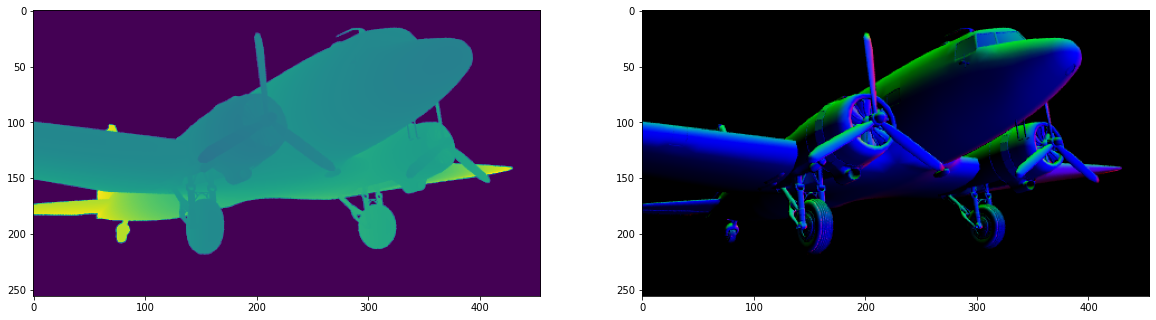

In [ ]:
# set cam_pose for target image
cp_tg = [-10.0, -2.0, 13.0]
lk_tg = [0.0, -0.0,  0.0]

cp_tg_tensor =  torch.tensor(cp_tg)
lk_tg_tensor = torch.tensor(lk_tg)

optim_cam_program.set_target_img(cp_tg_tensor, lk_tg_tensor)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scene construction, time: 0.04110 s
Forward pass, time: 0.02500 s


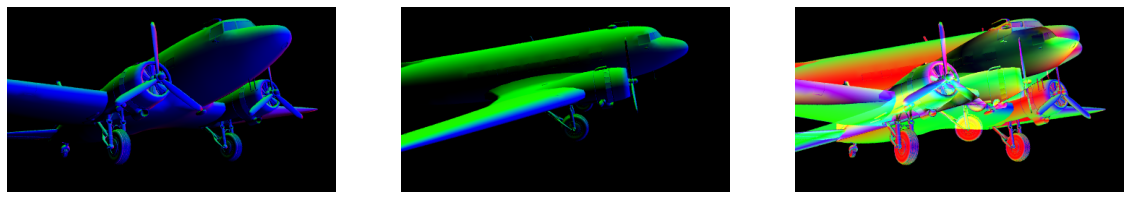

In [ ]:
#inintial pose
cam_pose =  torch.tensor([-20.0, 3.0, 2], device= pyredner.get_device(),  requires_grad=True )
lookat = torch.tensor([-6.0, 0.0,  0.50000], device= pyredner.get_device(), requires_grad=True)

optim_cam_program.set_source_img(cam_pose, lookat)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


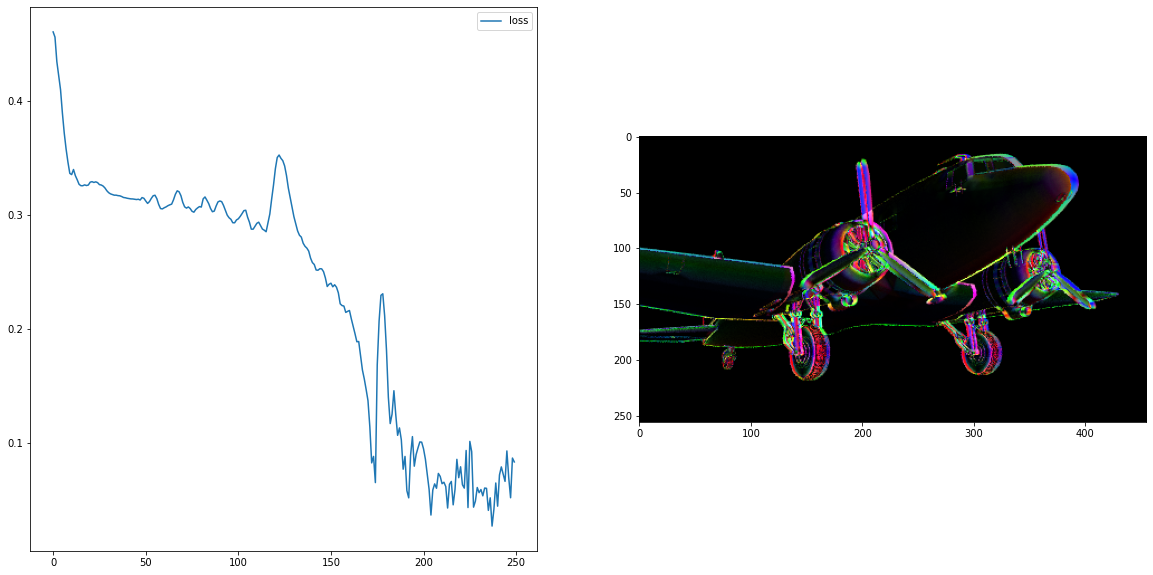

cam pose==== tensor([-10.0383,  -2.0041,  13.3050], device='cuda:0', requires_grad=True)
cam lookat=== tensor([-1.9505, -0.3967,  2.5838], device='cuda:0', requires_grad=True)


In [ ]:
optim_cam_program.optimization_process(250)

## save sequenses of images as video

In [1]:
# Convert the intermediate renderings to a video.
from subprocess import call

subdir = 'airplane'
name = 'diff'
call(["ffmpeg", "-framerate", "10", "-i",
    "results/test_g_buffer/{}/iter_{}_%d.png".format(subdir, name), "-vb", "30M",
    "results/test_g_buffer/{}/out_difference.avi".format(subdir)])

1

## counvert a list of images to animation

In [ ]:
# norml_imgs  -- a sequence of iterated noraml images

In [ ]:
def convert_imglist_to_animation(norml_imgs):
  %%capture
  from matplotlib import animation
  from IPython.display import HTML
  fig = plt.figure()
  im = plt.imshow(norml_imgs[0], animated=True)
  def update_fig(i):
      im.set_array(norml_imgs[i])
      return im,
  anim = animation.FuncAnimation(fig, update_fig, frames=len(norml_imgs), interval=50, blit=True)

  HTML(anim.to_jshtml())